The Project of Advanced Lane Finding
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import pickle as pickle
%matplotlib inline

### As for the camera calibration, please refer to the camera_calibration.ipynb

### 1.Undistort image

In [2]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('test_images/straight_lines1.jpg')

In [53]:
#function to undistort the origin image to destination image
def undistort(img,mtx=mtx,dist=dist):
    dst=cv2.undistort(img,mtx,dist,None,mtx)
    return dst

In [4]:
# test undistort function
dst= undistort(img,mtx,dist)

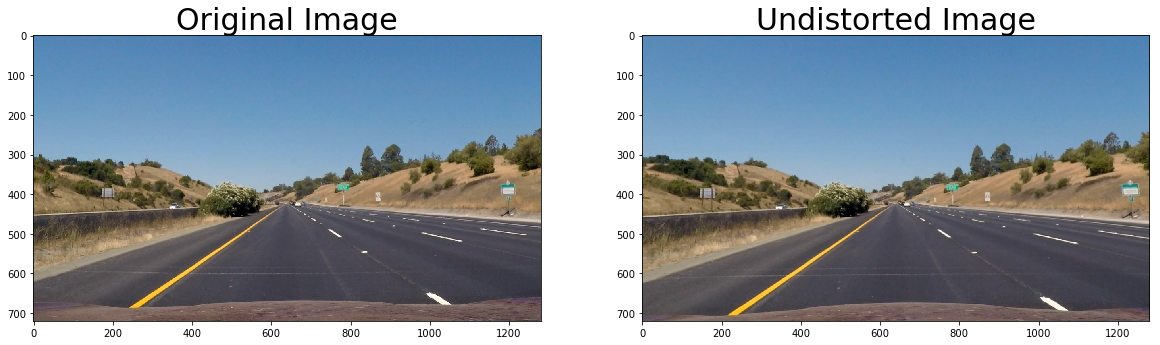

In [5]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.imshow(dst)

## 2.Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
image = dst.copy()

HSV color space (Using all three channels to identify yellow and white lines)
* We identify yellow color as the pixels whose HSV-transformed intensities are between \([ 0, 100, 100]\) and \([ 50, 255, 255]\), and white color as the pixels with intensities between \( [20, 0, 180]\) and \([255, 80, 255] \).

In [108]:
# Define a function that thresholds the channels of HSV
# Use exclusive lower bound (>) and inclusive upper (<=)
def hsv_select(img, ythreshLow=(0,100, 100),ythreshHigh=(50,255,255),
                              wthreshLow=(20, 0, 180),wthreshHigh=(255, 80, 255)):
    # 1) Convert to HSV color space
    # 2) Apply a threshold to the channels
    # 3) Return a binary image of threshold result
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary_output_y = np.zeros((img.shape[0], img.shape[1]))
    binary_output_w = np.zeros((img.shape[0], img.shape[1]))
    binary_output_both= np.zeros((img.shape[0], img.shape[1]))
    binary_output_y[(hsv[:,:,0] >= ythreshLow[0])
                    & (hsv[:,:,0] <= ythreshHigh[0]) 
                    & (hsv[:,:,1] >= ythreshLow[1])  
                    & (hsv[:,:,1] <= ythreshHigh[1])  
                    & (hsv[:,:,2] >= ythreshLow[2]) & (hsv[:,:,2] <= ythreshHigh[2])] = 1
    binary_output_w[(hsv[:,:,0] >= wthreshLow[0])
                    & (hsv[:,:,0] <= wthreshHigh[0]) 
                    & (hsv[:,:,1] >= wthreshLow[1])  
                    & (hsv[:,:,1] <= wthreshHigh[1])  
                    & (hsv[:,:,2] >= wthreshLow[2]) & (hsv[:,:,2] <= wthreshHigh[2])] = 1
    
    binary_output_both[(binary_output_y==1) | (binary_output_w==1)] =1
    
    return binary_output_both

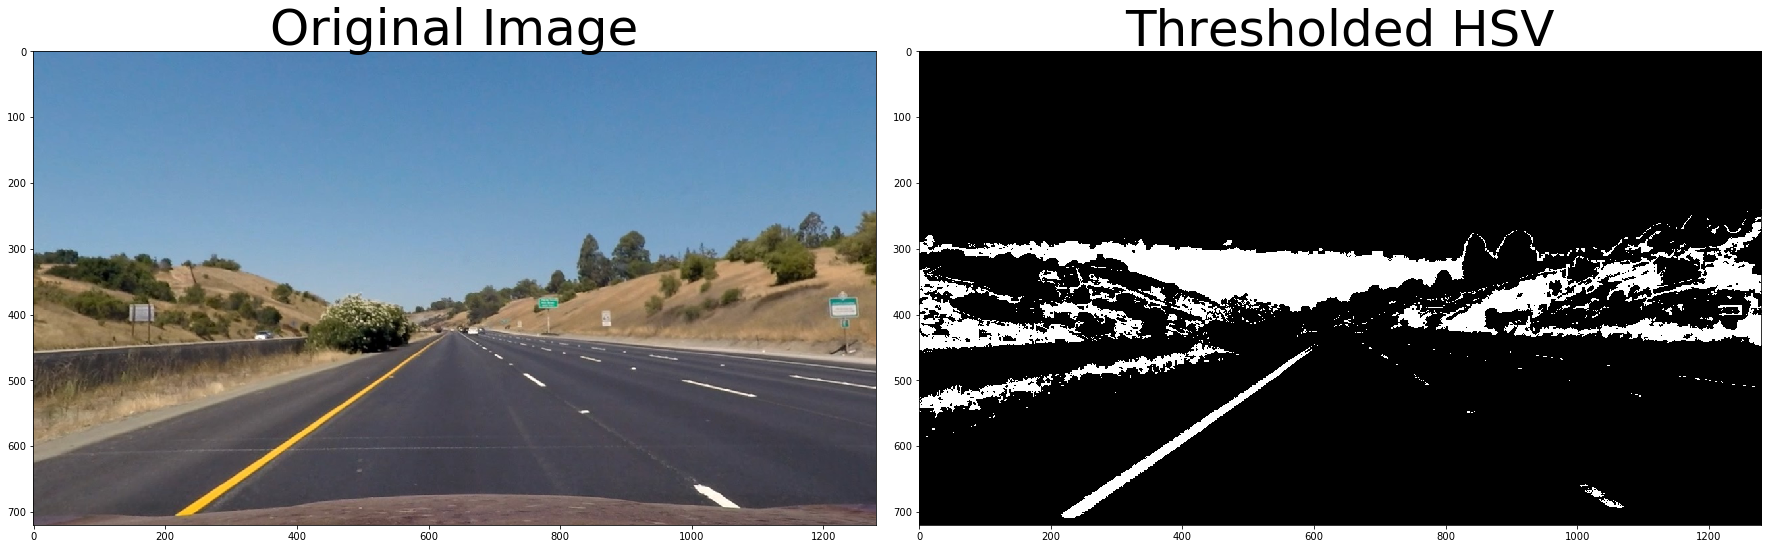

In [8]:
imgThres_both = hsv_select(image, ythreshLow=(0,100, 100),ythreshHigh=(50,255,255),
                              wthreshLow=(20, 0, 180),wthreshHigh=(255, 80, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(imgThres_both, cmap='gray')
ax2.set_title('Thresholded HSV', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Sobel Filter on LS of HLS color space

In [103]:
#Magnitude threshold
def sobel_x(img, sobel_kernel=9,min_thres = 80, max_thres =220):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output

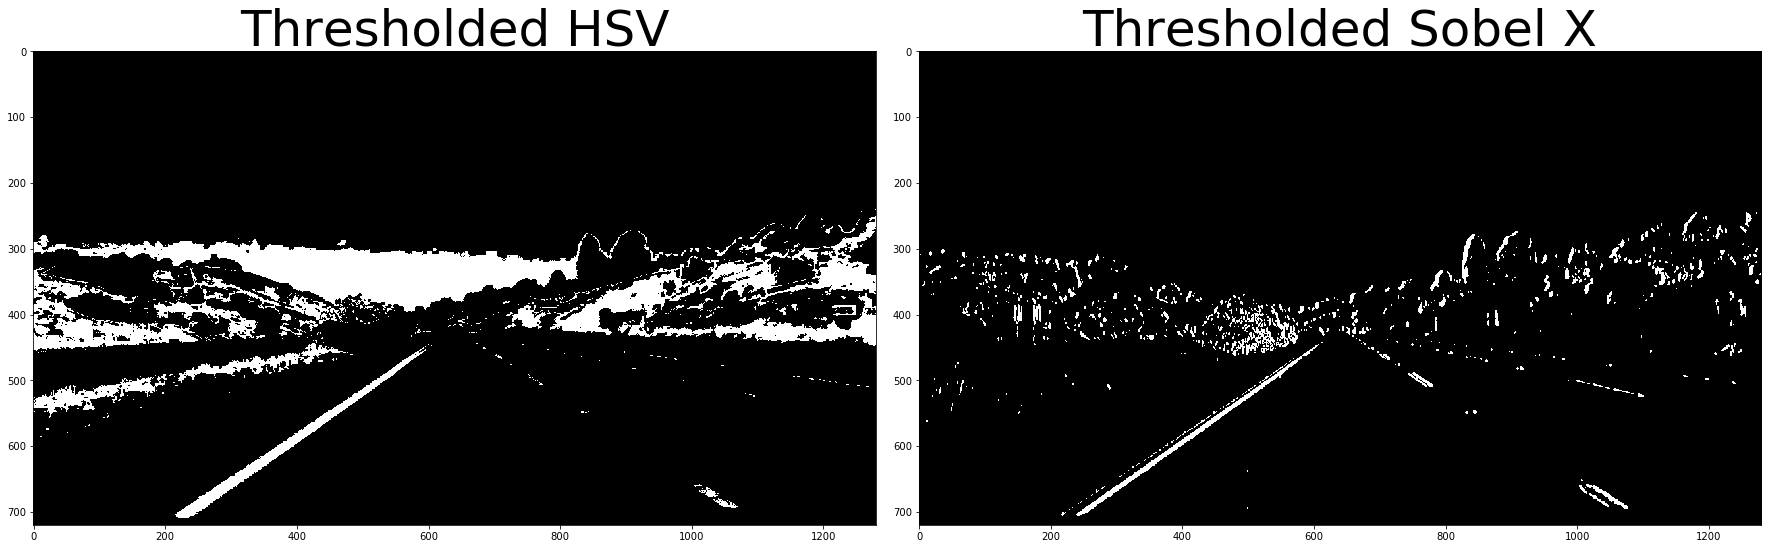

In [10]:
#Sobel x only
imgThres_sobel = sobel_x(image,9,80,220) #Sobel x

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imgThres_both, cmap='gray')
ax1.set_title('Thresholded HSV',fontsize=50)
ax2.imshow(imgThres_sobel, cmap='gray')
ax2.set_title('Thresholded Sobel X', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [121]:
#function to combine HSV and sobel x result
def hsv_sobel_combined(img):
    img1=hsv_select(img)
    img2=sobel_x(img)
    img_final=np.zeros_like(img1)
    img_final[(img1 ==1) | (img2 ==1)]=1
    return img_final

img_final= hsv_sobel_combined(image)

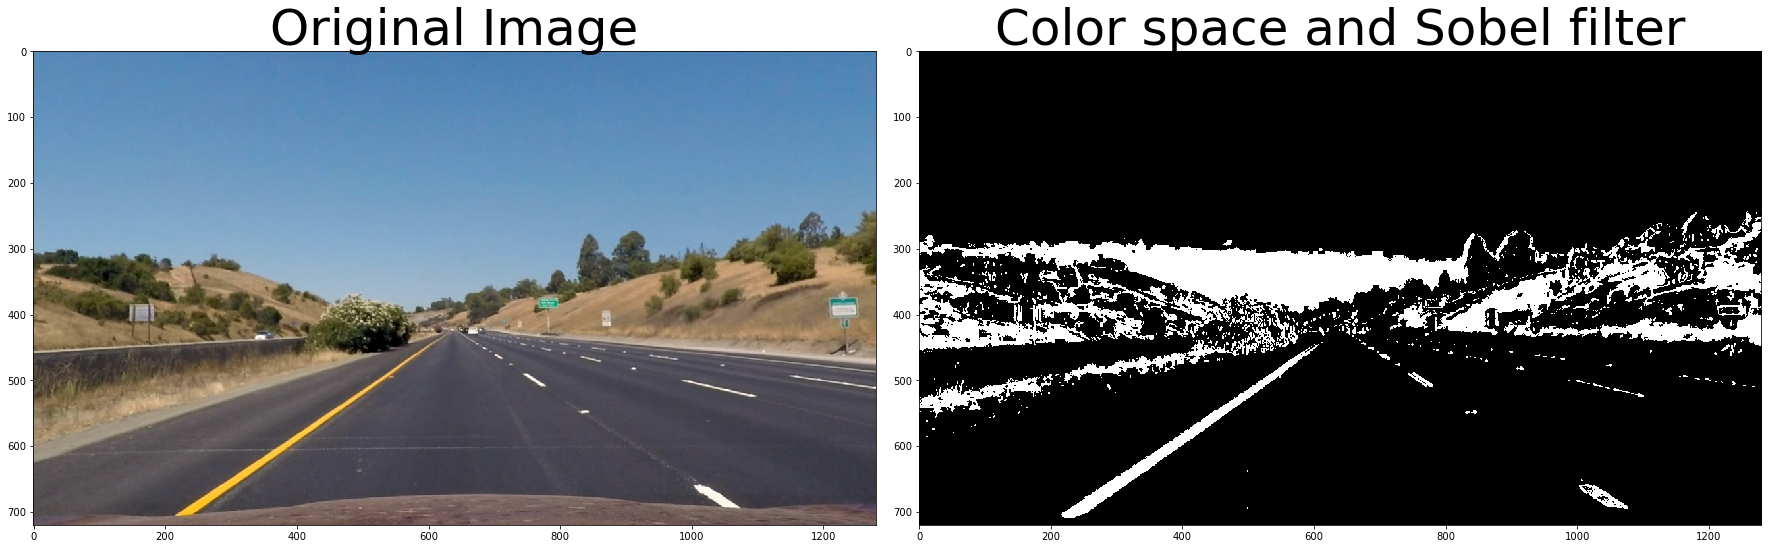

In [120]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image',fontsize=50)
ax2.imshow(img_final, cmap='gray')
ax2.set_title('Color space and Sobel filter', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3.Apply a perspective transform to rectify binary image ("birds-eye view")

In [13]:
img_size = (image.shape[1], image.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dstp = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

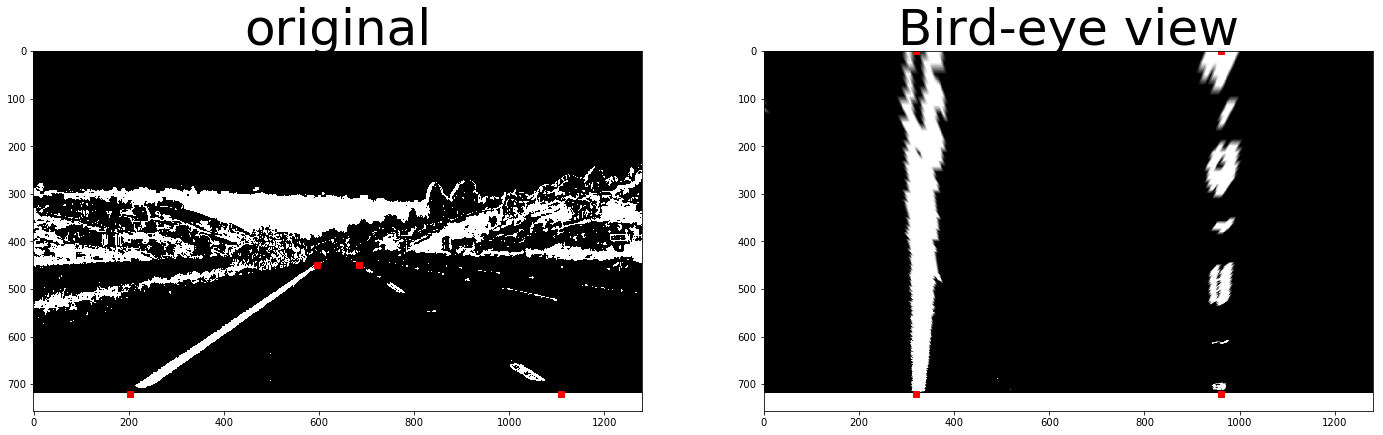

In [42]:
#Perspective transfomation
img_size = (image.shape[1], image.shape[0])

src = np.float32([[595, 450], [203, 720], [1110, 720], [685, 450]])
dstp = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M_persp = cv2.getPerspectiveTransform(src, dstp)
Minv_persp = cv2.getPerspectiveTransform(dstp, src)
binary_warped = cv2.warpPerspective(img_final, M_persp, img_size, flags=cv2.INTER_LINEAR)

plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.imshow(img_final,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original',fontsize=50)

plt.subplot(1,2,2)
plt.imshow(binary_warped,cmap='gray')
for i in range(4):
    plt.plot(dstp[i][0],dstp[i][1],'rs')
    
plt.title('Bird-eye view',fontsize=50)



In [75]:
#define perspective transformation function
def pers_trans(img,M_persp=M_persp,Minv_persp=Minv_persp,flag=0):
    img_size = (img.shape[1], img.shape[0])
    if flag==0: #pers_trans
        binary_warped = cv2.warpPerspective(img, M_persp, img_size, flags=cv2.INTER_LINEAR)
    else:       #unperspective transformation
        binary_warped =cv2.warpPerspective(img, Minv_persp, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped

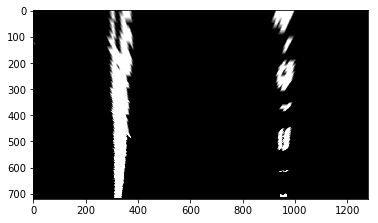

In [93]:
#test perspective transformation function
test_pers=pers_trans(img_final)
untest_pers=pers_trans(img_final,flag=1)
plt.imshow(test_pers,cmap='gray')

In [88]:
#Perspective transfomation test on curveture line
def plot_pers_trans(img):

    img2=undistort(img)

    RGB_warped=pers_trans(img2)
    
    img_unpersp = pers_trans(RGB_warped,flag=1)

    plt.figure(figsize=(14,9))

    plt.subplot(2,2,1)
    plt.title('Image')
    plt.imshow(img)

    plt.subplot(2,2,2)
    plt.title('Binary perspective')
    plt.imshow(RGB_warped)

    
    plt.subplot(2,2,3)
    plt.title('Unperspective')
    plt.imshow(img_unpersp)

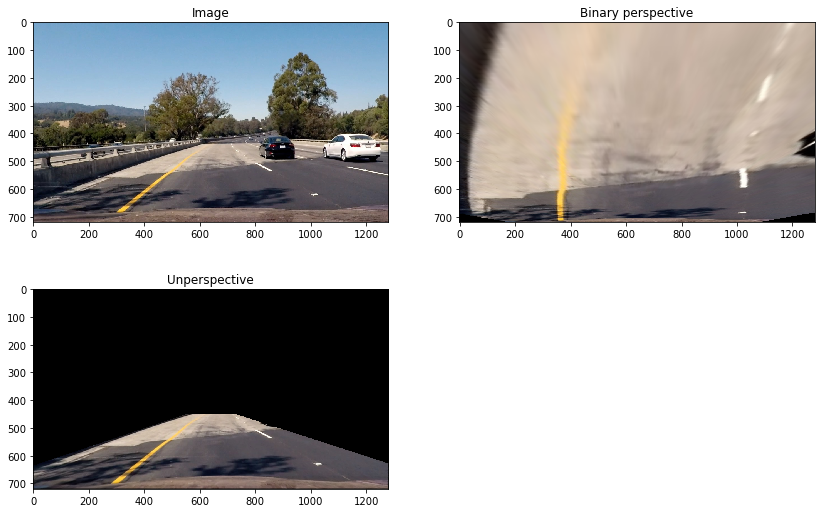

In [89]:
test4 = mpimg.imread("test_images/test4.jpg")
straight_lines2 = mpimg.imread("test_images/straight_lines2.jpg")
plot_pers_trans(test4)

## 4.Detect lane pixels and fit to find the lane boundary.

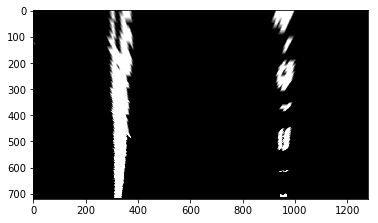

In [96]:
plt.imshow(test_pers,cmap='gray')

/home/patrick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


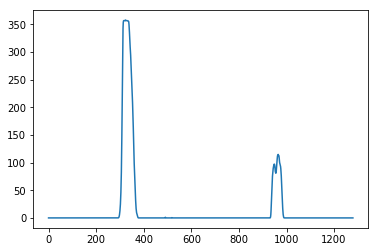

In [98]:
#Example histogram
histogram = np.sum(test_pers[test_pers.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [99]:
binary_warped=test_pers.copy()

In [100]:
#print(binary_warped.shape)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#plt.imshow(out_img)

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("leftx_base",leftx_base, "rightx_base",rightx_base)

nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()

leftx_base 324 rightx_base 965


In [101]:
def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

In [136]:
#fit the lines and return the left/right fit
def lrlines(img):
    #1.undistort img
    img_undist=undistort(img)
    #2.color space and sobel x
    img_both=hsv_sobel_combined(img_undist)
    #3.bird's view
    binary_warped=pers_trans(img_both)
    #4.fit lines
    left_fit, right_fit,out_img = fitlines(binary_warped)
    
    #5.get the x,y points coordinations
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (binary_warped,left_fit, right_fit,out_img)

In [145]:
#draw left and right lines
def plot_lrlines(img):
    
    binary_warped,left_fit, right_fit,out_img=lrlines(img)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(24,9))
    plt.subplot(1,2,1)
    plt.imshow(binary_warped, cmap='gray')

    plt.subplot(1,2,2)

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='blue')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    plt.subplot(1,2,2)
    binary_warped2 = np.zeros((720, 1280,3))
    binary_warped2[:,:,0] = binary_warped
    binary_warped2[:,:,1] = binary_warped
    binary_warped2[:,:,2] = binary_warped
    plt.imshow(out_img)
    result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
    plt.imshow(result)

/home/patrick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


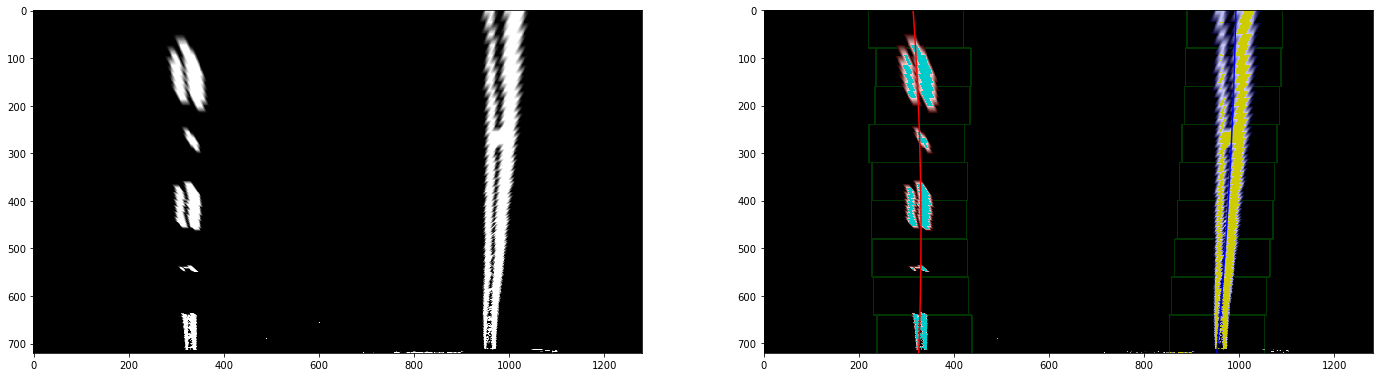

In [146]:
plot_lrlines(straight_lines2)

#### as we find the first frame's line coefficience, we use them to next frame

In [147]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated


## 5.Determine the curvature of the lane and vehicle position with respect to center.

In [148]:
#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    #leftx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    #rightx = right_fit[0]*ploty**2+right_fit[1]*ploty+left_fit[2]
        
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

## 6.Warp the detected lane boundaries back onto the original image.

In [171]:
#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    #print(np.int_(pts))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,200, 200))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    #print("undist", undist.shape)
    #print("newwarp", newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 0, newwarp, 1, 0)
    return(result, color_warp)

In [150]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)
        

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [179]:
binary_warped,ref_left, ref_right,out_img=lrlines(img)

/home/patrick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [180]:
#Function to process the image
global counter
counter=0
#ref_left =np.array([-0.0001,0,400])
#ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   



def process_image(img):
    
    global counter
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    #1.undistort img
    img_undist=undistort(img)
    #2.color space and sobel x
    img_both=hsv_sobel_combined(img_undist)
    #3.bird's view
    binary_warped=pers_trans(img_both)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    
    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #print(left_fit)
    #print(right_fit)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(img_both*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(img_both*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(img_both*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(img_birds,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curvature: " + str(int(left_curv)) + " m"
    TextR = "Right curvature: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (30,40), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (30,70), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (30,100), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Binary view", (1070,30), fontFace, .8,(0,200,200), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(0,200,200), thickness,  lineType = cv2.LINE_AA)
        
    
    #return img_out, binary_warped, left_curv, right_curv, left_fit, right_fit   
    return img_out 

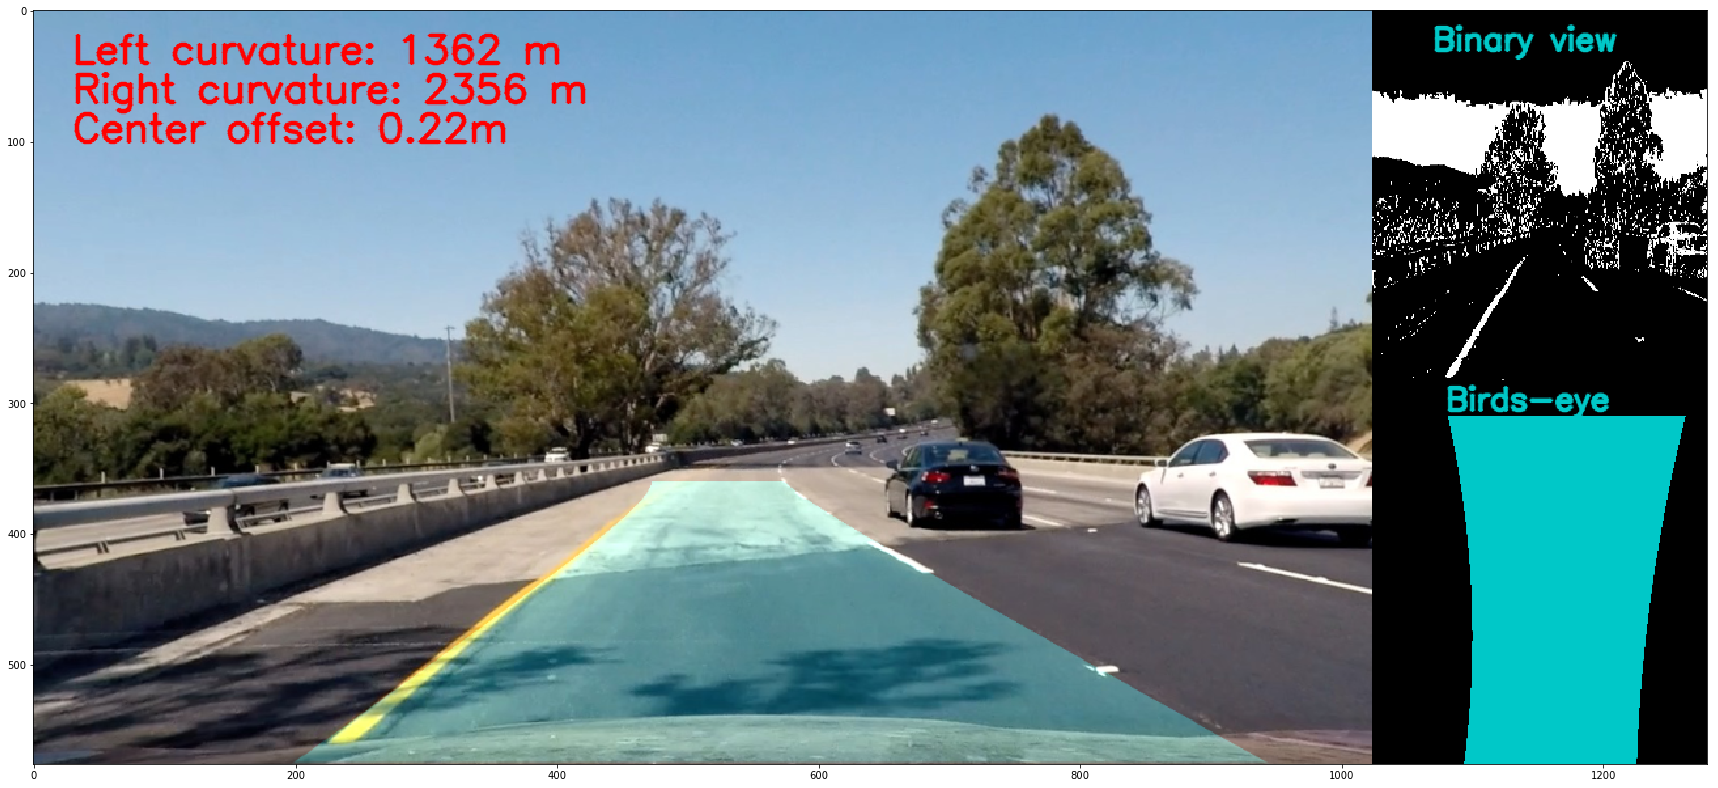

In [182]:
#test process img function
img = cv2.imread("test_images/test4.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

plt.figure(figsize=(10,15))
#plt.figure(figsize=(5,10))

  
plt.figure(figsize=(30,20))
plt.imshow(img2)

In [185]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [186]:
#Create video file pipeline
counter=0
output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


100%|█████████▉| 1260/1261 [03:56<00:00,  5.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 28min 51s, sys: 47.9 s, total: 29min 39s
Wall time: 3min 57s
1260


In [191]:
HTML("""
<video  width="720" height="400" controls>
  <source src="{0}">
</video>
""".format(output))